In [1]:
#
# LF test with noise
# C = S + N, where noise N = sigma^2 I, where I is the identity matrix
#
# We generate 20 values of parameters x for function logLF(x)
# We chose our parameters around the value of Boltzmann code generated C_3
# CAMB generated C_3 equals 5.88275e-10
#
# 1. Set all C_l = 0 except C_3  DONE
#
# 2. LF is based on a matrix C that only has a P_3 term. DONE
#
# 3. Add to that matrix a white noise term (sigma^2 on the diagonal). DONE
#
# 4. LF now has *exactly two* free parameters, C_3 and sigma^2. DONE
#
# 5. What is LF vs C_3 (at, perhaps, a couple values of sigma^2)? 
#
# 6. over-plot |a_3m|^2 values
#
#

In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

In [3]:
#
# Review of Likelihood Formalism:
#
# -2 loglikelihood is
# -2 ln L \propto m^T C^-1 m + lnDet C
# where C = S + N
# We are working with noiseless maps, N = 0, so C = S
#
# In real space, 
# data: the temperature map, 
# parameters: theoretical CAMB generated C_l, C^theory_l 
#
# m = array of temperature pixels
# S = S_ij
# N = diagonal noise (but here it is noiseless! N=0)
#
# In spherical harmonic space
# data: the Healpix anafast outputarray of a_lm (or similarly, \hat{C}_l )
# parameters: the theoretical C_l
#
# m = a_lm coefficients
# S is diagonal (C_2, C_3, etc.)
# N is non-sparse matrix (but here it is noiseless! N=0)
#
#
# NOTE: The correct standard is to systematically remove the monopole, dipole terms l=0,l=1
#       Also, we use in the following lmax = 2*nside

In [4]:
cd ~/Desktop/CMBintheLikeHoodz/Likelihood_Comparison

/Users/evanbiederstedt/Desktop/CMBintheLikeHoodz/Likelihood_Comparison


In [5]:
camb1 = "camb_nside16_lmax32_alms.fits"
camb2 = "camb_nside16_lmax32_map.fits"
camb3 = "camb_nside16_lmax32_scalcls.fits"
planck1 = "100GHz_nside16_lmax32_cls.fits"
planck2 = "100GHz_nside16_lmax32_cmb_alm.fits"
planck3 = "100GHz_nside16_lmax32_sky_alm.fits"
planck4 = "100GHz_nside16_lmax32_skymap.fits"

nside = 16

In [6]:
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print "The total number of pixels is " + str(npix)
print "The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX)
print "Healpix tells me total number of pixels npix is equal to " + str(heal_npix)

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072


In [7]:
#
# Begin with a Munich Planck-simulated map, and CAMB Boltzmann-code generated C_l values
#

In [8]:
# Theoretical scalar C_l array, CAMB
#
# open a FITS file, theoretical C_l values generated by CAMB
# type()=pyfits.hdu.hdulist.HDUList
cl_open = pf.open(camb3)
# recall camb3 = "camb_nside16_lmax32_scalcls.fits"

In [9]:
theoryCls_arr1 = cl_open[1].data
print theoryCls_arr1[:10]
# Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
# first two values are zero, i.e. monopole, dipole
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray

[(0.0, 0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0)
 (1.2639207e-09, 5.5308927e-14, 0.0, 3.6016001e-12)
 (5.8827504e-10, 4.5345086e-14, 0.0, 2.2704995e-12)
 (3.2867314e-10, 3.0680604e-14, 0.0, 1.4030458e-12)
 (2.065753e-10, 1.8198442e-14, 0.0, 8.6680196e-13)
 (1.4100289e-10, 9.6222612e-15, 0.0, 5.4035639e-13)
 (1.0233801e-10, 4.5884262e-15, 0.0, 3.3960166e-13)
 (7.7812937e-11, 2.0448748e-15, 0.0, 2.1437516e-13)
 (6.1362422e-11, 9.4503657e-16, 0.0, 1.3715881e-13)]


In [10]:
cltemps = theoryCls_arr1.field(0) 
print cltemps
print "The length of the array of theoretical Cl's is " +str(len(cltemps))
print "The array contains [C_0, C_1, C_2,..., C_" +str(len(cltemps)-1) + "]"
#print type(cltemps)=numpy.ndarray

[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]
The length of the array of theoretical Cl's is 33
The array contains [C_0, C_1, C_2,..., C_32]


In [11]:
# remove monopole l=0 and dipole l=1
theoryCl = cltemps[2:]
# len(theoryCl) = 31
print theoryCl
# theoryCl is np.ndarray of theoretical [C_2, C_3, C_4, ..., C_32]

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]


In [12]:
# Our input data is Gaerching generated, noiseless full-sky map
# Temperature map: here we use Planck simulated map from Munich, not CAMB map
# http://gavo.mpa-garching.mpg.de/planck/
#
# Read in with Healpy routine/function
#
# Use planck4 = "100GHz_nside16_lmax32_skymap.fits"
# This is a simulated data, 100GHz (where CMB dominates), no foregrounds
# 
mapread_camb2 = hp.read_map(camb2) # Healpix routine, input the sky map

NSIDE = 16
ORDERING = RING in fits file


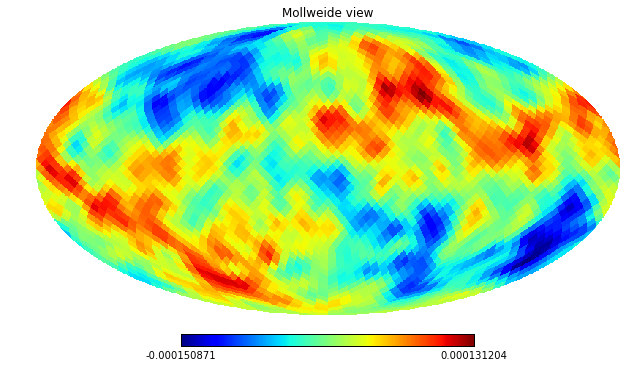

In [13]:
hp.mollview(mapread_camb2) # visualization of full-sky CMB map, nside=16, lmax=32

In [14]:
# The uploaded temperature map is mapread_planck4 = hp.read_map(planck4)
print type(mapread_camb2) # type(mapread_planck4) = np.ndarray
print mapread_camb2.shape # mapread_planck4.shape = (3072, ) = (N_pix, )
#
# rename array for convenience
tempval = mapread_camb2
#print tempval

<type 'numpy.ndarray'>
(3072,)


In [15]:
# Next, we use healpy map2alm to tranform to alm values
# Our input data is CAMB generated, noiseless full-sky map
# We calculate an array of a_lm from this by using Healpix map2alm, a subroutine of anafast
#
# map2alm only outputs m >=0 values, because m = -l values are equivalent to m = +l values
#
# Using map2alm, the length of the alm array is expected to be:
# (mmax * (2 * lmax + 1 - mmax)) / 2 + lmax + 1)"
#
# For mmax = lmax, this is l(l+1)/2 + l + 1
# i.e. 
# l = 0, there is 1
# l = 1, there is 3
# l = 2, there is 6
# l = 3, there is 10
# l = 4, there is 15
# etc.
almarr = hp.map2alm(mapread_camb2)                # This is an array of a_lm values
print "The array of spherical harmonic coefficients a_lm is"
#print almarr
print "The arr.shape is " + str(almarr.shape)
print "The length of a_lm array is " + str(len(almarr))
#
print "For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)"
print "However, this is NOT the order of the output! See below"
# In the Fortran F90 subroutines, complex alm are stored in an array that has 
# two dimensions to contain coefficients for positive and negative m values.
# Healpy doesn't do this....I think

print "============================="
print "============================="
print "Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)"
print "Default ordering of healpy.map2alm() output is "
print "(0,0), (1,0), ..., (lmax, 0),"
print "(1,1), (2,1), ...., (lmax, 1),"
print "(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax)."


The array of spherical harmonic coefficients a_lm is
The arr.shape is (1176,)
The length of a_lm array is 1176
For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)
However, this is NOT the order of the output! See below
Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)
Default ordering of healpy.map2alm() output is 
(0,0), (1,0), ..., (lmax, 0),
(1,1), (2,1), ...., (lmax, 1),
(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax).


In [16]:
# ==========================
# DEMONSTRATION
# Notice how a_lm is indexed
# ==========================

mmm = np.arange(12) # define a map, i.e. an array of 12 "pixels"
lmaxxx = 4
alm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
lm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
print(alm)
print(alm.shape)

# So alm is actually a 1D vector.
# How is alm indexed?


l, m = hp.Alm.getlm(lmax=lmaxxx)
print(l)

print(m)




print "The l values are "+str(l)
print "The m values are "+str(m)
print " (l,m) is in order " +str(list(zip(l,m)))
#
# l, m = hp.Alm.getlm(lmax=lmax)
# print(l)
# [0 1 2 1 2 2]
# print(m)
# [0 0 0 1 1 2]
#
#
# So, for l = 2, m is [0, 1, 2].
#
# ==========================
# Notice how a_lm is indexed
# ==========================
#
#
#

[  1.43186913e+01 +0.00000000e+00j  -9.06158785e+00 +0.00000000e+00j
  -7.57672587e+00 +0.00000000e+00j   5.38292381e+00 +0.00000000e+00j
   2.49127749e+00 +0.00000000e+00j   6.02204636e-01 -2.01587603e+00j
   4.55476051e-16 +1.48937220e-15j   2.43950547e-01 -3.28507898e-01j
  -2.47937026e-17 +3.49331635e-16j   3.65595455e-01 -7.92402132e+00j
   5.92284905e-17 -4.53852723e-15j  -3.16614952e-01 -1.44872968e+01j
  -2.28780515e-03 +4.33449165e-01j  -5.66350430e-16 +1.59192782e-15j
   1.08501635e+01 -3.35394518e-16j]
(15,)
[0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
The l values are [0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
The m values are [0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
 (l,m) is in order [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (1, 1), (2, 1), (3, 1), (4, 1), (2, 2), (3, 2), (4, 2), (3, 3), (4, 3), (4, 4)]


In [17]:
# Check with healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
ell, emm = hp.Alm.getlm(lmax=32)

print "len(ell) is " +str(len(ell))
print "len(emm) is "+str(len(emm))
print "l values are "+str(ell[:10])
print "m values are "+str(emm[:10])
pairs = list(zip(ell, emm)) # put values together in pairs, zip()
ellemm = np.vstack((ell,emm)).T  # equivalent to list(zip(ell,emm)), but uses numpy throughout
print "Indices for a_lm for lmax (l, m) are:" 
print str(pairs[:50]) # The expected output


len(ell) is 561
len(emm) is 561
l values are [0 1 2 3 4 5 6 7 8 9]
m values are [0 0 0 0 0 0 0 0 0 0]
Indices for a_lm for lmax (l, m) are:
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [18]:
print ellemm[:10]

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]
 [8 0]
 [9 0]]


In [19]:
#
# For our first test, mode l = 3, we need to access a_lm coefficients a_30, a_31, a_32, a_33
# To find this for lmax = 32, we use
# healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
# Find the indices
index_a30 = hp.Alm.getidx(lmax=32, l=3, m=0)
index_a31 = hp.Alm.getidx(lmax=32, l=3, m=1)
index_a32 = hp.Alm.getidx(lmax=32, l=3, m=2)
index_a33 = hp.Alm.getidx(lmax=32, l=3, m=3)

In [20]:
print "Index a_30 is " +str(index_a30)
print "Index a_31 is "+str(index_a31)
print "Index a_32 is "+str(index_a32)
print "Index a_33 is "+str(index_a33)

Index a_30 is 3
Index a_31 is 35
Index a_32 is 66
Index a_33 is 96


In [21]:
#
# Create an array with only the values a_3m, i.e. a_30, a_31, a_32, a_33
#
# First convert the array of alm coefficients into a real
#
realalm = almarr.real
#
print realalm[:36]

[  4.27365741e-10   2.29584030e-09  -3.99058124e-05  -3.54786292e-05
   2.10319852e-05   9.87750024e-06   7.97092193e-06  -1.18858780e-05
  -7.27840112e-06   3.61680988e-07  -4.90787138e-06   3.47579016e-06
  -4.30349062e-06  -2.65684938e-07  -1.00274382e-06  -1.12408678e-06
   4.89651663e-06   7.38091856e-07   2.10038079e-07   3.19967529e-06
  -2.82808712e-06   3.98389365e-07   9.92859235e-07   1.12017252e-07
   1.85264741e-06  -1.88066911e-06  -5.47687726e-07  -4.03524074e-08
   6.09934135e-07   6.46948184e-07  -2.27504639e-07   6.00326431e-07
  -1.16138884e-07   6.93299985e-09   3.15959247e-09   6.92273981e-09]


In [22]:
empty_almlist = []
#
a30 = realalm[3]
a31 = realalm[35]
a32 = realalm[66]
a33 = realalm[96]
#
print "a30 is " + str(a30)
print "a31 is " + str(a31)
print "a32 is " + str(a32)
print "a33 is " + str(a33)
#
print str(pairs[3]) # Check with our output above
print str(pairs[35])
print str(pairs[66])
print str(pairs[96])
#
empty_almlist.append(a30)
empty_almlist.append(a31)
empty_almlist.append(a32)
empty_almlist.append(a33)
#
print empty_almlist

a30 is -3.54786291692e-05
a31 is 6.92273981371e-09
a32 is -7.65807282676e-07
a33 is 2.69713402623e-05
(3, 0)
(3, 1)
(3, 2)
(3, 3)
[-3.5478629169177805e-05, 6.9227398137093788e-09, -7.6580728267559685e-07, 2.697134026229829e-05]


In [23]:
# create array of real-valued alm coefficients, a30 a31 a32 a33
realalm3 = np.asarray(empty_almlist) # np.asarray() converts input into an array
print realalm3

[ -3.54786292e-05   6.92273981e-09  -7.65807283e-07   2.69713403e-05]


In [24]:
# Repeat the above procedure for mode l = 4, i.e. a40 a41 a42 a43 a44
# Find the indices
index_a40 = hp.Alm.getidx(lmax=32, l=4, m=0)
index_a41 = hp.Alm.getidx(lmax=32, l=4, m=1)
index_a42 = hp.Alm.getidx(lmax=32, l=4, m=2)
index_a43 = hp.Alm.getidx(lmax=32, l=4, m=3)
index_a44 = hp.Alm.getidx(lmax=32, l=4, m=4)
#
print "Index a_40 is " +str(index_a40)
print "Index a_41 is "+str(index_a41)
print "Index a_42 is "+str(index_a42)
print "Index a_43 is "+str(index_a43)
print "Index a_44 is "+str(index_a44)
#
# Check with the above ouput
print str(pairs[4]) 
print str(pairs[36])
print str(pairs[67])
print str(pairs[97])
print str(pairs[126])
#
emptylistalm2 = []
#
#print realalm
#
a40 = realalm[4]
a41 = realalm[36]
a42 = realalm[67]
a43 = realalm[97]
a44 = realalm[127]
#
print "a40 is " + str(a40)
print "a41 is " + str(a41)
print "a42 is " + str(a42)
print "a43 is " + str(a43)
print "a44 is " + str(a44)
#
emptylistalm2.append(a40)
emptylistalm2.append(a41)
emptylistalm2.append(a42)
emptylistalm2.append(a43)
emptylistalm2.append(a44)
#
#print emptylistalm2

Index a_40 is 4
Index a_41 is 36
Index a_42 is 67
Index a_43 is 97
Index a_44 is 126
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
a40 is 2.10319852146e-05
a41 is 3.20500644244e-09
a42 is 3.94936640444e-07
a43 is 3.29951851271e-06
a44 is -1.19861955538e-09


In [25]:
# create array of real-valued alm coefficients, a40 a41 a42 a43 a44
realalm4 = np.asarray(emptylistalm2) # np.asarray() converts input into an array
print realalm4

[  2.10319852e-05   3.20500644e-09   3.94936640e-07   3.29951851e-06
  -1.19861956e-09]


In [26]:
# Calculate (abs(alm))**2 i.e. |alm|^2
abs_alm3 = np.absolute(realalm3)
abs_alm4 = np.absolute(realalm4)
print abs_alm3
print abs_alm4
# Now calculate the squares element-wise, x**2
alm3_squared = abs_alm3**2
alm4_squared = abs_alm4**2
print alm3_squared
print alm4_squared

[  3.54786292e-05   6.92273981e-09   7.65807283e-07   2.69713403e-05]
[  2.10319852e-05   3.20500644e-09   3.94936640e-07   3.29951851e-06
   1.19861956e-09]
[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]
[  4.42344402e-10   1.02720663e-17   1.55974950e-13   1.08868224e-11
   1.43668884e-18]


In [27]:
# For l = 3 test, we need theoretical value of C_3; ditto for l = 4
print theoryCl
C3 = theoryCl[1]
print "theory C_3 is " +str(C3)
C4 = theoryCl[2]
print "theory C_4 is "+str(C4)

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
theory C_3 is 5.88275e-10
theory C_4 is 3.28673e-10


In [28]:
# For lmax = 32, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(33)
print ell
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
print ellval 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]


In [29]:
# Calculate an array of (2*l + 1)C_l 
# i.e. 5*C_2, 7*C_3, 9*C_4, 11*C_5, 13*C_6, ...
print theoryCl

for i in ellval:
    paramsCl = (2*ellval + 1)*theoryCl # define array (2*l + 1)C_l 
    
print paramsCl

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
[  6.31960373e-09   4.11792528e-09   2.95805830e-09   2.27232828e-09
   1.83303757e-09   1.53507020e-09   1.32281992e-09   1.16588602e-09
   1.04627411e-09   9.52483075e-10   8.77029352e-10   8.14897868e-10
   7.63088029e-10   7.19523226e-10   6.82607653e-10   6.51016879e-10
   6.23691163e-10   5.99788922e-10   5.78633527e-10   5.59700893e-10
   5.42663609e-10   5.27274559e-10   5.13327074e-10   5.00646987e-10
   4.89086545e-10   4.78519364e-10   4.68836946e-1

In [30]:
norm = ((2*ellval + 1))/(4*math.pi)
print norm

[ 0.39788736  0.5570423   0.71619724  0.87535219  1.03450713  1.19366207
  1.35281702  1.51197196  1.6711269   1.83028185  1.98943679  2.14859173
  2.30774667  2.46690162  2.62605656  2.7852115   2.94436645  3.10352139
  3.26267633  3.42183128  3.58098622  3.74014116  3.89929611  4.05845105
  4.21760599  4.37676094  4.53591588  4.69507082  4.85422576  5.01338071
  5.17253565]


In [31]:
anafastCl = hp.anafast(mapread_camb2, lmax=32)
#len(anafastCl) = 33
# remove monopole and dipole values, l=0, l=1
hatCl = anafastCl[2:] #len() = 31, type() = np.ndarray
hatC3 = hatCl[1]   # index 0 = C2, 1 = C3, etc.
hatC4 = hatCl[2]
print hatC3
print hatC4

6.49352544114e-10
3.16267210302e-10


In [32]:
# 
# Add a_lm squared, |a_lm|^2
#
print "The values for |a_lm|^2 are : "
print "For |a_3m|**2 such that a_30, a_31, a_32, a_33: "
print str(alm3_squared)
print "And for |a_4m|**2 such that a_40, a_41, a_42, a_43, a_44: "
print str(alm4_squared)



The values for |a_lm|^2 are : 
For |a_3m|**2 such that a_30, a_31, a_32, a_33: 
[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]
And for |a_4m|**2 such that a_40, a_41, a_42, a_43, a_44: 
[  4.42344402e-10   1.02720663e-17   1.55974950e-13   1.08868224e-11
   1.43668884e-18]


In [33]:
# =========================================================================
#
# =========================================================================
#
# Data:
#     tempval      # the array of pixel values, (3072,)
#     realalm3     # array of alm values, a30, a31, a32, a33 
#     realalm4     # array of alm values, a40, a41, a42, a43, a44
#     alm3_squared # array of |alm|^2, (abs(a3m))**2
#     alm4_squared # array of |alm|^2, (abs(a4m))**2
#     hatCl        # array of anafast-calculated \hat{C}_l values, l=2 to l=32
#     hatC3        # \hat{C}_3 value
#     hatC4        # \hat{C}_4 value
#
# Parameters:
#     theoryCl     # array of Boltzmann code generated C_l, i.e. C^{theory}_l
#     paramsCl     # array of (2*l + 1)C_l from l=2 to l=lmax
#     C3           # array of C_3 value
#     C4           # array of C_4 value
#    
# Array of ell's: 
#     ellval       # array of l = 2 to l=lmax
#                  # [2 3 4 ... 31 32]
#     norm         # array of (2*l+1)/4pi
#                  # [5/4pi 7/4pi 9/4pi 11/4pi ... 63/4pi 65/4pi]
# =========================================================================
#
# =========================================================================

In [34]:
#
# Next, create the matrix, n_i /cdot n_j
# solely using Healpy routines, i.e. taking the dot product of the vectors
# The result is "dotproductmatrix"
#
# npix = 3072

In [35]:
totalpix = np.arange(npix) # An array indexing the total number of pixels

In [36]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple
#
#
vecval = hp.pix2vec(nside, totalpix) #Nside = 16, type()=tuple

In [37]:
vecvalx = vecval[0] #shape (3072,)
vecvaly = vecval[1]
vecvalz = vecval[2]

In [38]:
# First arrange arrays vertically
# numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays
totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [39]:
trans = totalvecval.T #transpose

In [40]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
# dotproductmatrix.shape = (npix, npix) = (3072, 3072)
# type(dotproductmatrix) = np.ndarray

In [41]:
# =========================================================
# =========================================================
#
# \Sum_l (2*l + 1)/4pi C^th_l P_l (dotproductmatrix)
# sum from l=2 to l=lmax
#
# arrays l = [2 3 4 .... lmax]
#        C_l = [C_2 C_3 .... C_lmax]
#
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         
#
#
# =========================================================
# =========================================================

In [42]:
# =========================================================
# =========================================================
#
# Now calculate the likelihood 
# -2lnL \propto m^T C^-1 m + ln det C + N ln (2pi)
#
# First term, m^T C^-1 m is the "model fit term"
# Second term, lndetC is the "complexity penalty"
# Third term, N ln 2pi, a constant
#
# m = tempval
# C = Sij
#
# STEP 1: do inverse of Sij
#        invSij = np.linalg.inv(Sij)
#
# STEP 2: do matrix mulplication, m.T*inv(C)*m
#       
# lnL_modelfit_terms = np.array([np.dot(tempval.T , np.dot(invSij[i] , tempval) ) for i in range(invSij.shape[0])])
#
# STEP 3: do logdet Sij
#
# logdetC = np.linalg.slogdet(Sij) #computes sign and log det C
# logdetC[1]
#
# STEP 4: compute N_pix * 2pi
#
# Npix2pi = (npix)*2*math.pi
#
# Step 5: -2loglikelihood = m.T*inv(C)*m + logdetC[1] + Npix2pi
# 
# =========================================================
# =========================================================

In [43]:
# CODE BOTTLENECK!
# 
# Evaluate Legendre from l=2 to l=lmax for each matrix entry
# [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# 
# WITHOUT BROADCASTING, one would do something like 
# PlMat = []
# for i in ellval:
#    PlMat.append( eval_legendre(i, dotproductmatrix) )
#
#
# With broadcasting, we use
PlMat = eval_legendre(ellval[:, None, None], dotproductmatrix)
# PlMat = [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# PlMat is an array, len()=31 of 31 3072 by 3072 matrices
# PlMat.shape = (31, 3072, 3072)

In [44]:
# multiply PlMat by (2*l+1)/4pi, i.e. norm
norm_matrix = norm[:, None, None] * PlMat
# [5/4pi * P_2(M)  7/4pi * P_3(M) ....   65/4pi * P_32(M)]

In [45]:
# JULY 1, 2015
#
#
# Here we define the LF 
#
# Next we should writen the REAL-space log-likelihood, -2 lnLikefunction
# this is a function of parameters
# plot against parameters, theory C_l
#
# Likelihood function should use -2lnL /propto m^T C^-1 M + log det M
#

In [46]:
# TEST C_3 Likelihood
#
# The covariance matrix is a function of variable "x" where "x" is "C_3", an unknown parameter. 
# 
# Our covariance matrix is therefore S_ij  = 7/4pi * x * P_3(matrix)   
# (We set l=3, i.e. l=3, and P_3)
# 
# The LF is then a function of x, LF(x). This is the only parameter we vary. 
#
# LF = -2loglikelihood /propto T^T inv(S_ij) T + log det (Sij) + N log (2pi)
# 
# We then plot LF(x) vs. parameters x. 
#

In [47]:
# define pixel-value arrays
mT = np.matrix(tempval)     # mT.shape = (1, 3072)
m = np.matrix(tempval).T    # m.shape = (3072, 1)
Npix2pi = (npix)*2*math.pi  # LF constant



In [48]:
print C3 # Boltzmann code CAMB output

5.88275e-10


In [49]:
# generate a number of samples to plot for x
# Boltzmann code value for C3 is 5.88275e-10
# start at 1e-10, end at 9e-10
# default samples generated is 50

In [50]:
vary_x_samples1 = np.linspace(1e-10, 9e-10, num=20 ) #set default num = 20

In [51]:
print vary_x_samples1

[  1.00000000e-10   1.42105263e-10   1.84210526e-10   2.26315789e-10
   2.68421053e-10   3.10526316e-10   3.52631579e-10   3.94736842e-10
   4.36842105e-10   4.78947368e-10   5.21052632e-10   5.63157895e-10
   6.05263158e-10   6.47368421e-10   6.89473684e-10   7.31578947e-10
   7.73684211e-10   8.15789474e-10   8.57894737e-10   9.00000000e-10]


In [52]:
# create Sij array, len()=31, l=2 to l=32
# Sij = norm_matrix * theoryCl[:, None, None]
# [5/4pi*C_2*P_2(M)  7/4pi*C_3*P_3(M) ....   65/4pi*C_32*P_32(M)]

In [53]:
print hatC3  # anafast generated C_l for l = 3 from sky map
print C3     # CAMB generated C_3, Boltzmann code output

6.49352544114e-10
5.88275e-10


In [54]:
print alm3_squared  # a_3m extracted from sky map, absolute value, squared

[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]


In [55]:
np.set_printoptions(threshold=100000)  # Default is threshold=1000
## Use this to print all values, disables corner printing

In [56]:
# print out all matrices and parts of the logLF
print vary_x_samples1  # generated from 1e-10 to 9e-10

[  1.00000000e-10   1.42105263e-10   1.84210526e-10   2.26315789e-10
   2.68421053e-10   3.10526316e-10   3.52631579e-10   3.94736842e-10
   4.36842105e-10   4.78947368e-10   5.21052632e-10   5.63157895e-10
   6.05263158e-10   6.47368421e-10   6.89473684e-10   7.31578947e-10
   7.73684211e-10   8.15789474e-10   8.57894737e-10   9.00000000e-10]


In [57]:
print Npix2pi # LogLF constant

19301.9452637


In [58]:
sigma2 = np.logspace(-12, -14, num=30 ) #set default num = 30
print sigma2

[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-14
   1.17210230e-14   1.00000000e-14]


In [59]:
print 7*hatC3
print hatC3

4.5454678088e-09
6.49352544114e-10


In [60]:
# Second test with rescaled values
vary_x_samples3 = np.logspace(-8, -12, num=30) #num = 30 
sigma3 = np.logspace(-12, -14, num=30)

In [61]:
print vary_x_samples3
print sigma3

[  1.00000000e-08   7.27895384e-09   5.29831691e-09   3.85662042e-09
   2.80721620e-09   2.04335972e-09   1.48735211e-09   1.08263673e-09
   7.88046282e-10   5.73615251e-10   4.17531894e-10   3.03919538e-10
   2.21221629e-10   1.61026203e-10   1.17210230e-10   8.53167852e-11
   6.21016942e-11   4.52035366e-11   3.29034456e-11   2.39502662e-11
   1.74332882e-11   1.26896100e-11   9.23670857e-12   6.72335754e-12
   4.89390092e-12   3.56224789e-12   2.59294380e-12   1.88739182e-12
   1.37382380e-12   1.00000000e-12]
[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-1

In [62]:
# For N matrix, set the identity
id_mat = np.identity(3072)
# print id_mat    # This is a (3072, 3072) matrix

In [63]:
noiseresult = sigma2[:, None, None] * id_mat[None, :, :]
#print noiseresult

In [64]:
# Now, rescale
#
# Multiply the CMB maps by 1e6 and the C matrix entries by 1e12 and try again.
#
tempp = (1e6)*tempval # multiply CMB maps by 1e6

def LogLikehood_wNoise_1e12(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

In [65]:
print sigma3
print "*************"
print vary_x_samples3

[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-14
   1.17210230e-14   1.00000000e-14]
*************
[  1.00000000e-08   7.27895384e-09   5.29831691e-09   3.85662042e-09
   2.80721620e-09   2.04335972e-09   1.48735211e-09   1.08263673e-09
   7.88046282e-10   5.73615251e-10   4.17531894e-10   3.03919538e-10
   2.21221629e-10   1.61026203e-10   1.17210230e-10   8.53167852e-11
   6.21016942e-11   4.52035366e-11   3.29034456e-11   2.39502662e-11
   1.74332882e-11   1.26896100e-11   9.23670857e-12   6.72335754e-12
   4.89390092e-12   3.56224789e-12   2.59294380e-12  

In [66]:
print vary_x_samples3
print sigma3

[  1.00000000e-08   7.27895384e-09   5.29831691e-09   3.85662042e-09
   2.80721620e-09   2.04335972e-09   1.48735211e-09   1.08263673e-09
   7.88046282e-10   5.73615251e-10   4.17531894e-10   3.03919538e-10
   2.21221629e-10   1.61026203e-10   1.17210230e-10   8.53167852e-11
   6.21016942e-11   4.52035366e-11   3.29034456e-11   2.39502662e-11
   1.74332882e-11   1.26896100e-11   9.23670857e-12   6.72335754e-12
   4.89390092e-12   3.56224789e-12   2.59294380e-12   1.88739182e-12
   1.37382380e-12   1.00000000e-12]
[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-1

In [67]:
np.logspace(-8.3, -10, num=40)

array([  5.01187234e-09,   4.53325612e-09,   4.10034607e-09,
         3.70877741e-09,   3.35460219e-09,   3.03424945e-09,
         2.74448928e-09,   2.48240018e-09,   2.24533968e-09,
         2.03091762e-09,   1.83697212e-09,   1.66154773e-09,
         1.50287575e-09,   1.35935639e-09,   1.22954263e-09,
         1.11212562e-09,   1.00592153e-09,   9.09859552e-10,
         8.22971159e-10,   7.44380301e-10,   6.73294595e-10,
         6.08997324e-10,   5.50840217e-10,   4.98236910e-10,
         4.50657034e-10,   4.07620869e-10,   3.68694506e-10,
         3.33485475e-10,   3.01638783e-10,   2.72833338e-10,
         2.46778711e-10,   2.23212211e-10,   2.01896228e-10,
         1.82615847e-10,   1.65176674e-10,   1.49402882e-10,
         1.35135431e-10,   1.22230472e-10,   1.10557891e-10,
         1.00000000e-10])

In [68]:
#FIRST, NO PEAK CODE, i.e. scale covariance matrix by e+21
#CODE
#https://gist.github.com/evanbiederstedt/a763375f068b05167c26
#
# Hold sigma^2 constant, vary C3
#

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-8, -12, num=40) # C3 parameter, vary from e-08 to e-12
sigma125 = 5e-22 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e21)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e21)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 6120.85396532  6076.65563341  6024.66001787  6187.68092862  6061.96277583
  6047.18578629  6038.57450971  6030.98652264  6029.21553204  6028.48221659
  6025.20435033  6022.74028081  6022.30222239  6022.88968283  6021.47561007
  6021.35078551  6021.08334537  6020.83818906  6020.57419857  6020.67151055
  6020.67966353  6020.58572085  6020.42228451  6020.38809076  6020.4011259
  6020.37376419  6020.3725417   6020.36415689  6020.3147651   6020.33330363
  6020.31574263  6020.31825891  6020.31827825  6020.30846731  6020.30552062
  6020.30506617  6020.30254519  6020.30341397  6020.30116094  6020.29990949]
******************
logdetC terms are
[-1910.79269502 -1899.49346143 -1894.31400072 -1893.9865907  -1890.0321336
 -1889.55785882 -1889.79498435 -1890.52858638 -1891.04930553 -1892.56437866
 -1893.64297778 -1895.06109716 -1896.61902812 -1898.36601353 -1899.78459156
 -1901.39518245 -1903.05163531 -1904.67733691 -1906.32176722 -1907.95386497
 -1909.59522293 -1911.21625436 

In [69]:
#SECOND, THERE IS A PEAK CODE, i.e. scale covariance matrix by e+22
#CODE

#
# Hold sigma^2 constant, vary C3
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1

vary_x_samples123 = np.logspace(-8, -12, num=40) # C3 parameter, vary from e-08 to e-12
sigma123 = 5e-22 # chose this sigma^2 parameter, hold constant
#
# Plot noise sigma from e-22 to e-24
#
 
Sij = vary_x_samples123 [:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e22)*Sij   # multiply S_ij by 1e12
Nij = sigma123 * id_mat[None, :, :]
newNij = (1e22)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 616.406231    619.05185498  612.63837544  622.61211289  616.47739678
  615.04842876  615.09587829  613.96735491  613.97526654  613.75222174
  613.84361628  613.76274137  613.78519219  613.83672808  613.78294773
  613.73891148  613.80203704  613.77018163  613.77959263  613.78272514
  613.78295674  613.78551855  613.77332932  613.7759883   613.77187851
  613.76700221  613.77169002  613.77015905  613.771929    613.7696702
  613.77052443  613.770897    613.77002111  613.76877367  613.76953128
  613.76928608  613.7690226   613.76928199  613.76949369  613.76944293]
******************
logdetC terms are
[ 5162.11916985  5174.89668376  5179.54501215  5178.57071109  5182.81051551
  5184.46873299  5183.19398907  5183.19703352  5182.37013867  5181.01067721
  5179.97913256  5178.52226416  5176.80653401  5175.16623507  5173.76193185
  5172.11691893  5170.45643259  5168.87473124  5167.23262542  5165.6055479
  5163.95696043  5162.3116691   5160.67301514  5159.02720484  5157.3792

In [70]:
#
#We can do the same tests with holding C3 and varying the sigma^2 noise parameter:
#
#First use C3 = 5e-10, and then try 10% less, i.e. C3=4.5e-10
#
#FIRST CODE, fix C3 = 5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#We use C3 = 5e-10
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples125 = 5e-10
sigma125 = np.logspace(-21, -23, num=40)

Sij = vary_x_samples125 * norm_matrix[1][None, :, :]
newSij = (1e21)*Sij # multiply S_ij by 1e12
Nij = sigma125[:, None, None] * id_mat[None, :, :]
newNij = (1e21)*Nij
#Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
#Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij) # returns sign and determinant; use logdetC[1]
#model_fit_terms = m^T C^-1 m
#
#model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
#for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "****************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[   3072.52437155    3457.60368117    3890.90517116    4378.09266839
    4927.47673893    5545.55505572    6240.13710544    7021.1352493
    7903.07786615    8891.06160613   10007.97099047   11260.82652639
   12672.95974292   14264.20775935   16046.20137385   18068.0895861
   20326.04374195   22882.72904419   25751.42350931   28993.24731692
   32642.79469935   36753.871033     41403.50105152   46601.53303069
   52563.58867194   59657.20447722   62674.17104725   74446.46753761
   84074.77957646   94936.94957894  107811.12758196  126328.92440705
  134372.5410211   153704.7193144   170714.4805202   195972.28325917
  222962.1154264   257252.72343494  295359.47077126  330001.82906605]
****************
logdetC terms are
[   226.9052794    -135.07131727   -496.90121724   -858.84168741
  -1220.95683913  -1583.00135661  -1944.915235    -2306.69141473
  -2668.93133159  -3030.70976015  -3393.04701702  -3754.86449285
  -4117.08237295  -4478.81252165  -4840.70266103  -5203.6069

In [71]:
#SECOND CODE, C3 fixed to 4.5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#Now use C3 = 4.5e-10
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples125 = 4.5e-10
sigma125 = np.logspace(-21, -23, num=40)

Sij = vary_x_samples125 * norm_matrix[1][None, :, :]
newSij = (1e21)*Sij # multiply S_ij by 1e12
Nij = sigma125[:, None, None] * id_mat[None, :, :]
newNij = (1e21)*Nij
#Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
#Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij) # returns sign and determinant; use logdetC[1]
#model_fit_terms = m^T C^-1 m
#
#model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
#for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "****************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[   3067.40837851    3452.05589257    3884.55112422    4372.38101382
    4919.812718      5536.97928904    6230.41640543    7012.23221265
    7890.34171163    8881.4720157     9994.13875287   11249.91260935
   12659.99217924   14247.68386625   16029.98113663   18044.66013206
   20299.52623366   22862.92061601   25737.46803025   28965.11233265
   32600.50310536   36711.61642227   41366.00273793   46518.80487927
   52435.80731085   58999.23119779   66947.06402115   74409.06939153
   84112.15188368   94875.85332279  107481.16976504  121521.93196731
  137076.13041609  156235.16156381  181720.74413212  194193.59369195
  222754.55463613  254707.29084638  293031.46721927  334180.71087709]
****************
logdetC terms are
[   226.14698827   -135.84459125   -497.77721029   -859.75520288
  -1221.57421951  -1583.58370644  -1945.50163755  -2307.47734396
  -2669.46947982  -3031.47381079  -3393.45016261  -3755.63967164
  -4117.84099712  -4479.54633844  -4842.03114024  -5203.78

In [72]:
#FIRST, FIND NO PEAK IN LF, NOISE PARAMETERS E-22 TO E-24
#
#CODE, C3 = 5e-10:

#
#Hold C3 fixed, then do test again with 10% less C3 value
#Use C3=5e-10
#
#Noise is now varied from e-22 to e-24
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples123 = 5e-10
sigma123 = np.logspace(-22, -24, num=40)

Sij = vary_x_samples123 * norm_matrix[1][None, :, :]
newSij = (1e22)*Sij # multiply S_ij by 1e12
Nij = sigma123[:, None, None] * id_mat[None, :, :]
newNij = (1e22)*Nij
#Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
#Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij) # returns sign and determinant; use logdetC[1]
#model_fit_terms = m^T C^-1 m
#
#model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
#for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ])

print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[  2.99585015e+03   3.36873264e+03   3.79629488e+03   4.27820109e+03
   4.81407623e+03   5.43719315e+03   6.25216832e+03   6.83630316e+03
   7.75340430e+03   8.73175883e+03   9.88544939e+03   1.12069993e+04
   1.21256654e+04   1.42164646e+04   1.44109998e+04   1.80392826e+04
   2.04937103e+04   2.33640316e+04   2.71390411e+04   3.69281748e+04
   3.58844828e+04   4.43699190e+04   6.98135949e+04   6.09136289e+04
   2.02841572e+05   7.77723824e+04  -4.55406024e+04   6.51272393e+04
   6.45087271e+03   1.07007828e+05  -1.26056716e+05   3.15951306e+05
   1.88302951e+02  -2.51195123e+04  -4.82495845e+04   3.56136674e+05
   8.67624125e+04  -6.90490445e+04   4.22610420e+04  -2.33418012e+04]
******************
logdetC terms are
[   239.71699157   -122.71079135   -486.33852385   -849.25504606
  -1212.4921126   -1576.26351061  -1944.85327619  -2305.753459
  -2669.13822474  -3030.65420367  -3396.41771088  -3763.82736171
  -4131.60575246  -4506.35071982  -4889.11466545  -5248.40

In [73]:
#SECOND CODE, 
#C3 = 4.5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#Now use C3=4.5e-10
#
#Noise is now varied from e-22 to e-24
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples123 = 4.5e-10
sigma123 = np.logspace(-22, -24, num=40)

Sij = vary_x_samples123 * norm_matrix[1][None, :, :]
newSij = (1e22)*Sij # multiply S_ij by 1e12
Nij = sigma123[:, None, None] * id_mat[None, :, :]
newNij = (1e22)*Nij
#Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
#Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij) # returns sign and determinant; use logdetC[1]
#model_fit_terms = m^T C^-1 m
#
#model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
#for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ])

print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[    3108.47334151     3497.81044692     3943.34892076     4438.3098074
     4996.10099797     5641.32168072     6389.69578891     7420.59466635
     7860.44681883     8958.80520598    10131.72497116    11431.62527848
    12955.45118996    14694.00133738    16732.9311529     18694.37141759
    21043.0078146     24049.01057686    27700.55451291    32177.59884332
    35812.55767554    41345.61803947    43320.19815405    59716.30457363
    57079.87189435   127379.79706994    94065.27953167   -34972.02516217
    45445.39167403   119469.85713562     4396.14593734   -30714.01932548
  -223376.93037036   -52476.7676687    -90186.27170558    29592.39663792
    -7740.72438949   122508.93510534   -30885.22435457  1411638.00779926]
******************
logdetC terms are
[   238.87906146   -123.59978549   -486.97635053   -849.54919459
  -1212.63010956  -1576.01604717  -1942.33073337  -2309.73321034
  -2670.91431763  -3031.09627919  -3396.32588831  -3762.14204865
  -4128.07960518 

vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40
sigma12 = np.logspace(-21, -23, num=40)
LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


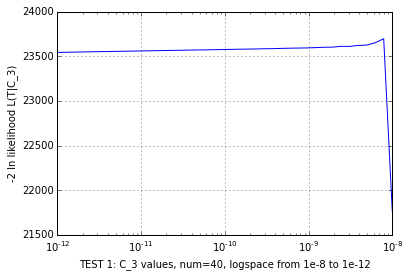

In [74]:
#FIRST, NO PEAK CODE, i.e. scale covariance matrix by e+21
#CODE
#https://gist.github.com/evanbiederstedt/a763375f068b05167c26
#
# Hold sigma^2 constant, vary C3
#
#[  4.97838906e-03   1.19436354e-05   2.79293997e-04   3.14480045e-03]

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-8, -12, num=40) # C3 parameter, vary from e-08 to e-12
sigma125 = 5e-22 # chose this sigma^2 parameter, hold constant

def LogLikehood_wNoise_1e21(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e21)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e21)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis125 = vary_x_samples125
yaxis125 = LogLikehood_wNoise_1e21(vary_x_samples125, sigma125)

fig125 = plt.figure()
plt.plot(xaxis125, yaxis125)
plt.xscale("log")
plt.xlabel('TEST 1: C_3 values, num=40, logspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma12 = np.logspace(-21, -23, num=40)"
print "LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40
sigma123 = np.logspace(-22, -24, num=40)
LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


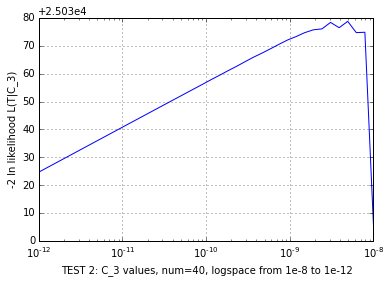

In [75]:
#SECOND, THERE IS A PEAK CODE, i.e. scale covariance matrix by e+22
#CODE

#
# Hold sigma^2 constant, vary C3
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1

vary_x_samples123 = np.logspace(-8, -12, num=40) # C3 parameter, vary from e-08 to e-12
sigma123 = 5e-22 # chose this sigma^2 parameter, hold constant
#
# Plot noise sigma from e-22 to e-24
#
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e22)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e22)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_x_samples123
yaxis123 = LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('TEST 2: C_3 values, num=40, logspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma123 = np.logspace(-22, -24, num=40)"
print "LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40
sigma12 = np.logspace(-21, -23, num=40)
LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


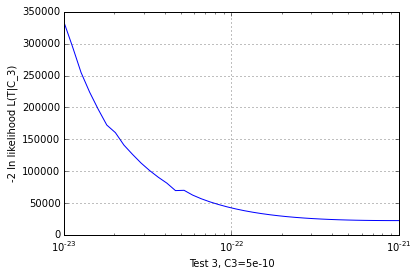

In [76]:
#
#We can do the same tests with holding C3 and varying the sigma^2 noise parameter:
#
#First use C3 = 5e-10, and then try 10% less, i.e. C3=4.5e-10
#
#FIRST CODE, fix C3 = 5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#We use C3 = 5e-10
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples125 = 5e-10
sigma125 = np.logspace(-21, -23, num=40)

def LogLikehood_wNoise_1e21(param, sig):
    # param is our parameter, C_3
    Sij = param * norm_matrix[1][None, :, :]
    newSij = (1e21)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e21)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


xaxis125 = sigma125
yaxis125 = LogLikehood_wNoise_1e21(vary_x_samples125, sigma125)

fig125 = plt.figure()
plt.plot(xaxis125, yaxis125)
plt.xscale("log")
plt.xlabel('Test 3, C3=5e-10')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma12 = np.logspace(-21, -23, num=40)"
print "LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40
sigma12 = np.logspace(-21, -23, num=40)
LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


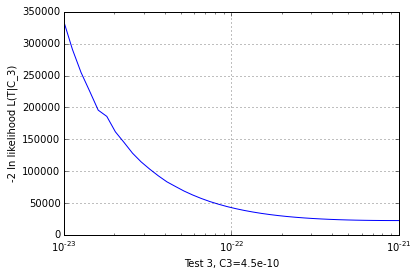

In [77]:
#SECOND CODE, C3 fixed to 4.5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#Now use C3 = 4.5e-10
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples125 = 4.5e-10
sigma125 = np.logspace(-21, -23, num=40)

def LogLikehood_wNoise_1e21(param, sig):
    # param is our parameter, C_3
    Sij = param * norm_matrix[1][None, :, :]
    newSij = (1e21)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e21)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


xaxis125 = sigma125
yaxis125 = LogLikehood_wNoise_1e21(vary_x_samples125, sigma125)

fig125 = plt.figure()
plt.plot(xaxis125, yaxis125)
plt.xscale("log")
plt.xlabel('Test 3, C3=4.5e-10')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma12 = np.logspace(-21, -23, num=40)"
print "LogLikehood_wNoise_1e20(vary_x_samples12, sigma12)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40
sigma123 = np.logspace(-22, -24, num=40)
LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


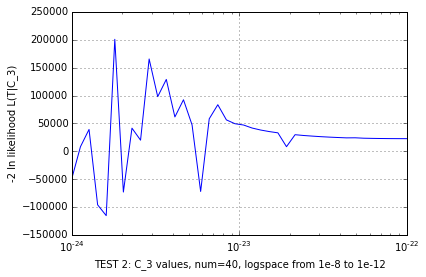

In [78]:
#FIRST, FIND NO PEAK IN LF, NOISE PARAMETERS E-22 TO E-24
#
#CODE, C3 = 5e-10:

#
#Hold C3 fixed, then do test again with 10% less C3 value
#Use C3=5e-10
#
#Noise is now varied from e-22 to e-24
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples123 = 5e-10
sigma123 = np.logspace(-22, -24, num=40)
#
# Plot noise sigma from e-22 to e-24
#
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param * norm_matrix[1][None, :, :]
    newSij = (1e22)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e22)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = sigma123
yaxis123 = LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('TEST 2: C_3 values, num=40, logspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma123 = np.logspace(-22, -24, num=40)"
print "LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"


vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40
sigma123 = np.logspace(-22, -24, num=40)
LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)
|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


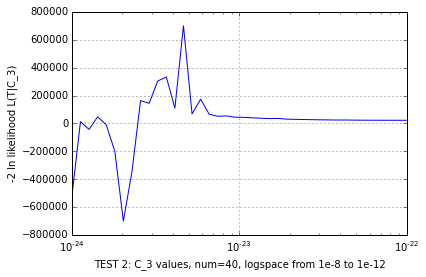

In [79]:
#SECOND CODE, 
#C3 = 4.5e-10
#
#Hold C3 fixed, then do test again with 10% less C3 value
#Now use C3=4.5e-10
#
#Noise is now varied from e-22 to e-24
#
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1
#
vary_x_samples123 = 4.5e-10
sigma123 = np.logspace(-22, -24, num=40)

#
# Plot noise sigma from e-22 to e-24
#
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param * norm_matrix[1][None, :, :]
    newSij = (1e22)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e22)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = sigma123
yaxis123 = LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('TEST 2: C_3 values, num=40, logspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

print "vary_x_samples123 = np.logspace(-8, -12, num=40) #num = 40"
print "sigma123 = np.logspace(-22, -24, num=40)"
print "LogLikehood_wNoise_1e22(vary_x_samples123, sigma123)"
print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"


In [80]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-5 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e5)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e5)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 613.8567454   613.85676038  613.85677934  613.85680335  613.85683375
  613.85687226  613.85692102  613.85698277  613.85706096  613.85715997
  613.85728535  613.85744412  613.85764514  613.85789967  613.85822194
  613.85862995  613.85914646  613.85980029  613.86062784  613.86167511
  613.86300021  613.86467646  613.86679628  613.86947609  613.87286222
  613.87713834  613.88253436  613.88933722  613.8979036   613.90867465
  613.92219252  613.93911801  613.9602481   613.98653097  614.01907479
  614.05914484  614.10814115  614.16754732  614.23884046  614.32335404]
******************
logdetC terms are
[ 5019.77504944  5018.12194956  5016.46885984  5014.81578299  5013.16272242
  5011.50968249  5009.85666868  5008.20368796  5006.55074912  5004.89786334
  5003.24504474  5001.5923112   4999.93968537  4998.28719593  4996.63487916
  4994.98278102  4993.33095966  4991.67948868  4990.02846119  4988.377995
  4986.72823905  4985.07938169  4983.43166085  4981.78537702  4980.1409

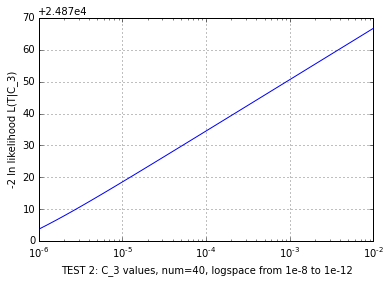

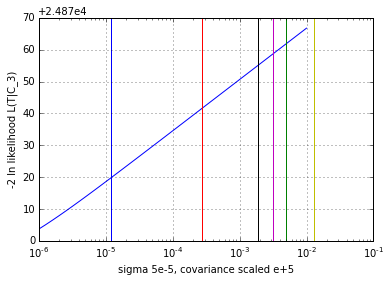

In [81]:

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-5 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e5)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e5)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('TEST 2: C_3 values, num=40, logspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-5, covariance scaled e+5')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [82]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-6 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e6)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e6)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 597.71603846  597.71603918  597.71604009  597.71604124  597.71604269
  597.71604454  597.71604687  597.71604983  597.71605358  597.71605832
  597.71606433  597.71607193  597.71608157  597.71609376  597.71610921
  597.71612877  597.71615355  597.71618492  597.71622464  597.71627494
  597.71633864  597.71641929  597.71652141  597.71665072  597.71681443
  597.71702169  597.71728408  597.7176162   597.71803655  597.7185685
  597.71924152  597.72009283  597.72116934  597.72253006  597.72424921
  597.72641983  597.72915834  597.73260988  597.73695466  597.74241527]
******************
logdetC terms are
[ 5035.89301624  5034.23988203  5032.58674885  5030.93361695  5029.28048668
  5027.62735847  5025.97423288  5024.32111059  5022.6679925   5021.01487971
  5019.36177364  5017.70867608  5016.0555893   5014.40251617  5012.74946031
  5011.09642634  5009.44342009  5007.79044893  5006.13752221  5004.48465177
  5002.83185259  5001.17914364  4999.52654895  4997.87409893  4996.221

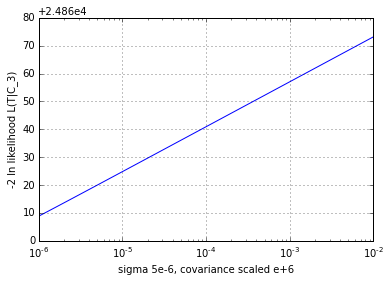

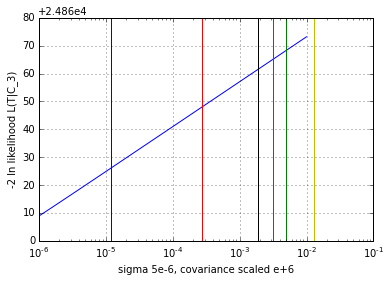

In [83]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-6 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e6)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e6)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-6, covariance scaled e+6')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-6, covariance scaled e+6')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()



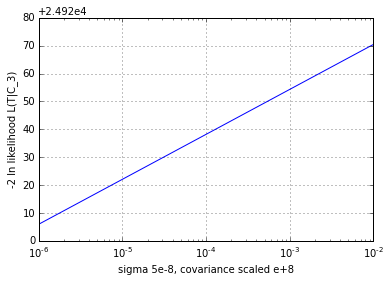

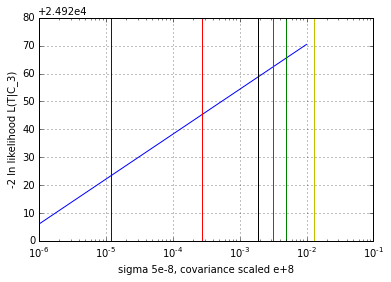

In [84]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-8 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e8)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e8)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-8, covariance scaled e+8')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-8, covariance scaled e+8')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [85]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-8 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e8)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e8)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 608.49344103  608.49344104  608.49344106  608.49344107  608.49344109
  608.49344111  608.49344113  608.49344117  608.49344122  608.49344128
  608.49344136  608.49344145  608.49344157  608.49344173  608.49344193
  608.49344218  608.49344249  608.49344289  608.4934434   608.49344404
  608.49344486  608.49344589  608.49344719  608.49344884  608.49345093
  608.49345358  608.49345694  608.49346118  608.49346656  608.49347338
  608.493482    608.49349293  608.49350676  608.49352428  608.49354647
  608.49357456  608.49361014  608.49365519  608.49371224  608.49378449]
******************
logdetC terms are
[ 5068.12919332  5066.47605532  5064.8229174   5063.16977943  5061.51664151
  5059.8635036   5058.21036571  5056.55722786  5054.90409004  5053.25095228
  5051.59781458  5049.94467697  5048.29153947  5046.6384021   5044.98526491
  5043.33212794  5041.67899124  5040.02585489  5038.37271899  5036.71958365
  5035.06644902  5033.4133153   5031.76018272  5030.10705159  5028.45

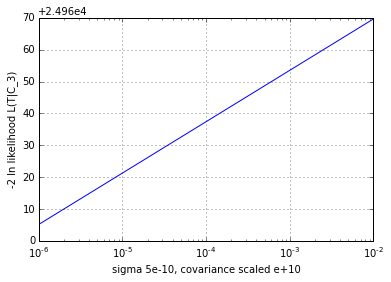

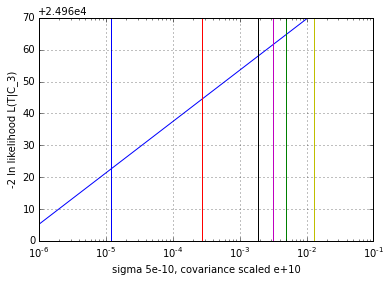

In [86]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-10 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e10)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e10)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-10, covariance scaled e+10')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-10, covariance scaled e+10')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [87]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-10 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e10)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e10)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 625.69290875  625.69291401  625.6929137   625.69291356  625.69291293
  625.69291335  625.69291372  625.69291324  625.69291379  625.69291352
  625.69291375  625.6929135   625.6929134   625.69291368  625.69291361
  625.69291358  625.69291361  625.69291365  625.69291363  625.69291364
  625.69291364  625.69291368  625.69291366  625.6929137   625.69291372
  625.69291374  625.69291377  625.69291381  625.69291385  625.69291391
  625.69291399  625.69291409  625.69291421  625.69291436  625.69291455
  625.6929148   625.69291511  625.6929155   625.692916    625.69291663]
******************
logdetC terms are
[ 5100.36538078  5098.71224161  5097.05910329  5095.40596782  5093.75283063
  5092.09969216  5090.44655516  5088.7934178   5087.14027939  5085.48714171
  5083.83400359  5082.18086601  5080.52772816  5078.87459018  5077.22145211
  5075.56831419  5073.91517617  5072.26203827  5070.60890028  5068.95576232
  5067.30262434  5065.64948635  5063.99634843  5062.34321047  5060.69

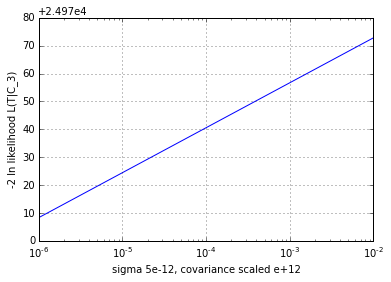

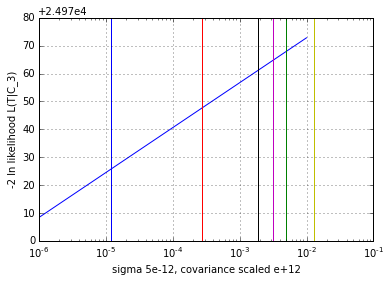

In [88]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-12 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-12, covariance scaled e+12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-12, covariance scaled e+12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [89]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-12 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e12)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e12)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 604.13019009  604.13013899  604.13012858  604.13025379  604.13018702
  604.13013238  604.13017012  604.13016236  604.13018159  604.1301765
  604.13017929  604.13017514  604.13017066  604.1301693   604.1301638
  604.13016669  604.1301706   604.13016785  604.13017019  604.13016737
  604.13016933  604.13016774  604.13016656  604.13016756  604.13016721
  604.13016769  604.13016745  604.13016763  604.13016752  604.13016746
  604.13016764  604.13016754  604.13016753  604.13016754  604.1301675
  604.13016752  604.1301675   604.13016754  604.13016753  604.13016756]
******************
logdetC terms are
[ 5132.60132767  5130.94790532  5129.29508855  5127.64185938  5125.98885593
  5124.33566089  5122.68264674  5121.02956872  5119.37640161  5117.72326216
  5116.07012158  5114.41702511  5112.76390171  5111.11076466  5109.45762823
  5107.8044867   5106.15135311  5104.49822323  5102.84508485  5101.19195041
  5099.53881175  5097.88567185  5096.23253855  5094.57939912  5092.92626

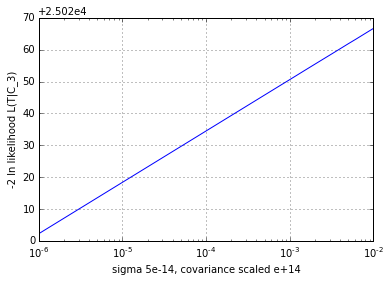

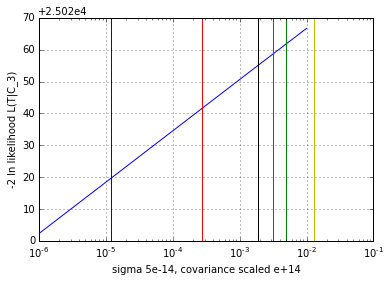

In [90]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-14 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e14)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e14)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-14, covariance scaled e+14')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-14, covariance scaled e+14')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [91]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-14 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e14)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e14)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 609.90702419  609.89319572  609.88782449  609.89753234  609.89637953
  609.89613352  609.89593237  609.89476558  609.89534815  609.89452354
  609.89548081  609.89423756  609.8937753   609.89380166  609.89474819
  609.89434287  609.89438808  609.8942809   609.8942448   609.89429909
  609.89421787  609.89427402  609.89419866  609.89418514  609.89419897
  609.8942102   609.89422671  609.89422672  609.89418937  609.89419637
  609.89419857  609.89418194  609.89418973  609.89418553  609.89418478
  609.89419146  609.89418827  609.89418833  609.89419043  609.894187  ]
******************
logdetC terms are
[ 5164.79510105  5163.13413744  5161.4937176   5159.85805885  5158.19660127
  5156.54910649  5154.90708779  5153.26117855  5151.60666208  5149.95277803
  5148.29873016  5146.64995743  5144.99795473  5143.34655631  5141.69150927
  5140.03954904  5138.38635062  5136.73328387  5135.08058491  5133.42777159
  5131.77455698  5130.12140095  5128.46857022  5126.81530656  5125.16

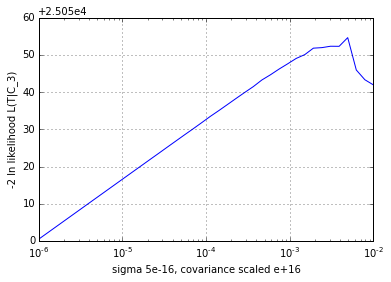

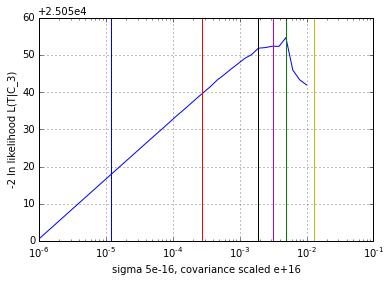

In [92]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-16 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e16)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e16)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-16, covariance scaled e+16')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-16, covariance scaled e+16')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [93]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-16 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e16)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e16)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[ 603.32084153  599.64349467  592.9130123   626.01294694  603.04228661
  600.37777383  598.68199342  598.00007096  597.758671    597.44141699
  597.37422073  597.02697405  597.00516244  596.91493756  596.95796053
  596.88884272  596.87379914  596.87773696  596.8714881   596.83160646
  596.82961884  596.82409873  596.81520673  596.80690747  596.80745587
  596.80503713  596.80042495  596.79572052  596.79973109  596.79665942
  596.79669096  596.79439388  596.79503995  596.79439654  596.79414917
  596.7942104   596.79390541  596.79393336  596.79385143  596.79364124]
******************
logdetC terms are
[ 5164.99295509  5172.90827247  5178.14185036  5177.91280226  5182.26310035
  5183.44204764  5183.80462775  5183.8246028   5182.13807875  5181.2094001
  5179.73261595  5178.47866056  5176.92407364  5175.4499553   5173.70421785
  5172.09860122  5170.51802323  5168.8842623   5167.21943558  5165.62819874
  5163.96211012  5162.29608146  5160.6811491   5159.03375247  5157.380

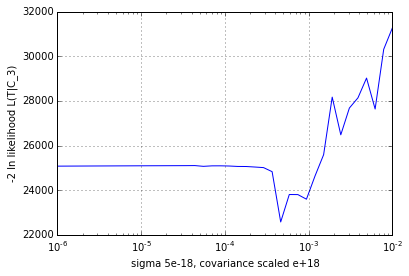

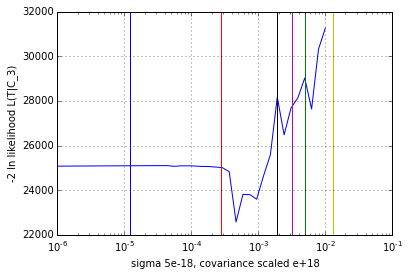

In [94]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-18 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e18)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e18)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-18, covariance scaled e+18')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-18, covariance scaled e+18')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [95]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-18 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e18)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e18)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[  67.91939327  -20.45128892 -120.94505874  259.75531523 -137.19851951
   74.79732206  200.97049526  789.86538337  296.55361168  970.92435572
  564.46568589  368.31043233  684.64812151  894.31980452  747.43337267
  739.05867634  669.56956515  664.57183409  645.44358377  641.81383459
  643.53052869  636.6060669   628.67322251  635.5234001   633.52395709
  632.14881772  631.70071728  631.47686431  631.57393743  631.14204323
  631.26653647  631.17086405  631.02455189  631.12560431  631.00690091
  631.03790618  631.0748609   631.0348981   631.02798481  631.04338654]
******************
logdetC terms are
[ 11967.01137129  11067.79908129  10472.28316982   9787.56753738
   8919.97364384   8340.80989265   7657.21476567   6842.20022194
   6309.34703011   5713.27086781   5093.84554126   4776.20850098
   4547.91668591   4577.7616935    4818.43811613   4995.86698094
   5070.16945357   5120.62810051   5142.28842732   5161.17666455
   5171.97525255   5177.00687349   5178.62745022

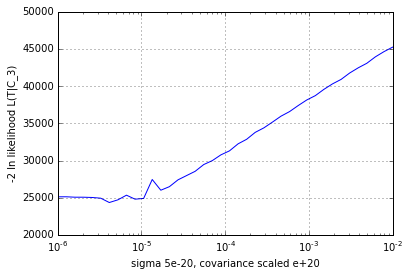

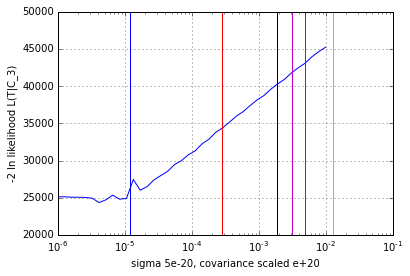

In [96]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-20 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e20)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e20)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-20, covariance scaled e+20')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-20, covariance scaled e+20')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


In [97]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1

vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-20 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e20)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e20)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[  1.95710087e-01   5.97023336e-01  -2.36278737e+00   3.30771983e-01
   4.38866342e+00  -4.78819627e-01  -6.60994256e-01  -2.74451350e+00
   4.07040896e+00  -3.18067659e+00  -6.52512250e+00  -9.21634469e+00
  -9.76696124e-01  -7.69894577e-01   9.70400801e+00  -1.12937148e+01
  -3.39610772e+01   3.37221219e+01  -2.41025212e+02   2.71662282e+02
   2.22007379e+01  -5.78223766e+01  -7.92556289e+01   2.20698656e+02
   1.74270702e+02   1.16105775e+02  -5.14946975e+01  -7.47864810e+02
   1.19680702e+03  -4.78533507e+02  -1.82477482e+03   1.63923392e+03
   5.31549075e+02   1.12736831e+03   7.34661007e+02   7.82350742e+02
   6.93879415e+02   6.67758199e+02   6.72074583e+02   6.62355605e+02]
******************
logdetC terms are
[ 25938.90895002  25339.04530167  24640.66553729  23773.91591372
  23171.3067174   22462.43703363  21601.95133985  21005.15871799
  20268.38050824  19436.36456593  18835.16213098  18070.21744866
  17271.75622975  16661.61895737  15861.48971037  15106.

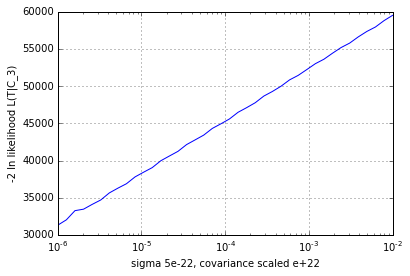

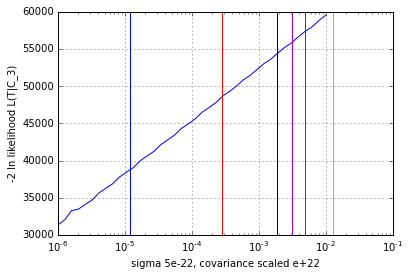

In [98]:
tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1


vary_C3 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-22 # chose this sigma^2 parameter, hold constant
 
def LogLikehood_wNoise_1e22(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e22)*Sij   # multiply S_ij by 1e12
    Nij = sig * id_mat[None, :, :]
    newNij = (1e22)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi



xaxis123 = vary_C3
yaxis123 = LogLikehood_wNoise_1e22(vary_C3, sigma125)

fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-22, covariance scaled e+22')
plt.ylabel('-2 ln likelihood L(T|C_3)')
#plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
#plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
#plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
#plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
#plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
#plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()


fig123 = plt.figure()
plt.plot(xaxis123, yaxis123)
plt.xscale("log")
plt.xlabel('sigma 5e-22, covariance scaled e+22')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =4.97838906e-03, color = 'g')  # a30 = 4.97838906e-03 
plt.axvline(x = 1.19436354e-05, color = 'b' ) # a31 = 1.19436354e-05
plt.axvline(x =2.79293997e-04, color = 'r')  # a32 =  2.79293997e-04
plt.axvline(x =3.14480045e-03, color = 'm')  # a33 = 3.14480045e-03
plt.axvline(x =0.0130704715226, color = 'y') # 7*\hat{C}_3 = 0.0130704715226
plt.axvline(x =0.00186721021751, color = 'k')  # \hat{C}_3 = 0.00186721021751
plt.grid()

In [99]:
# Hold sigma^2 constant, vary C3
#
# Begin at sigma^2 = 1e-5
#
## a30 = 4.97838906e-03 
# a31 = 1.19436354e-05
# a32 =  2.79293997e-04
# a33 = 3.14480045e-03
# 7*\hat{C}_3 = 0.0130704715226
# \hat{C}_3 = 0.00186721021751

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1

vary_x_samples125 = np.logspace(-2, -6, num=40) # C3 parameter, vary from e-02 to e-06
sigma125 = 5e-22 # chose this sigma^2 parameter, hold constant
 
Sij = vary_x_samples125[:, None, None] * norm_matrix[1][None, :, :]
newSij = (1e22)*Sij   # multiply S_ij by 1e12
Nij = sigma125 * id_mat[None, :, :]
newNij = (1e22)*Nij
# Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
# Sij.shape = (40, 3072, 3072)
Cij = newSij + newNij
#invCij = np.linalg.inv(Cij)
logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
# model_fit_terms = m^T C^-1 m
#
# model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
# for i in range(invCij.shape[0])])
#
model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
print "m^T c^-1 m terms are"
print model_fit_terms 
print "******************"
print "logdetC terms are"
print logdetC[1] 
print "******************"
print "Npix2pi term is"
print Npix2pi

m^T c^-1 m terms are
[  3.49428208e-03  -3.91449747e-02  -9.42889624e-04   2.53480685e-02
   1.24372382e-03  -6.33149202e-03  -9.02272823e-03  -1.06472859e-02
  -2.26274871e-01   2.47755427e-02   2.31060368e-02   1.24777976e-01
  -6.04750840e-02   9.55181781e-02  -7.60858991e-03   6.83365153e-01
   2.96545476e-01  -2.56097721e-01   1.21956318e-01   3.81147437e-01
   1.07227774e+01  -8.14076850e-01  -4.52724891e-01   1.76815651e+01
  -2.32383494e+00   1.67757868e+00  -9.50191923e-01   1.07243606e+00
  -2.22808923e-01   4.04802633e+00   9.05227073e+00  -3.08348760e+00
  -1.51157996e+01   6.53054168e+00  -2.66614215e+00  -7.87627788e+00
   2.84901584e+01   2.93114550e+02   2.84361758e+01   3.25764977e+01]
******************
logdetC terms are
[ 40216.72499319  39504.42476157  38647.3990099   38051.20611712
  37318.21647721  36485.38304578  35886.67491741  35124.64051987
  34316.05413071  33715.14768995  32921.94537866  32144.30421043
  31541.86473411  30687.04380524  29983.14898428  29364.